# Analog: Ana(lyzing) Log(s)

This notebook uses [analog](https://github.com/apparebit/analog) to analyze
webserver access logs for my personal website
[apparebit.com](https://apparebit.com). The analysis starts simple enough, by
invoking `latest_log_data()`. It returns a Pandas dataframe with the log data
and some basic metadata (called *coverage*). The simplicity of that single
function call is purposeful but also hides a number of preparatory steps, all
performed by analog:

 1. Parse monthly access logs to convert unstructured text into structured data;
 2. Add derrived columns such as `cool_path` or `status_class` that simplify
    analysis;
 3. Correlate some columns with other databases, notably for domain
    names, IP locations, and user agent classification.

Analog processes each monthly access log provided by my hosting provider on its
own and saves the results as Parquet files. If the corresponding Parquet file
already exists, it skips that month. After processing the monthly logs, analog
combines all dataframes into a single one, also saved in Parquet format. It also
creates a JSON sidecar file with the coverage information. If the monthly logs
didn't change and the combined dataframe already exists, analog skips this step
too. Since DNS lookups are by far the slowest operations amongst the above
preparatory steps, analog caches them in a `hostnames.json` file. That speeds up
the re-processing of monthly log data — after, for example, updating the
ingestion logic — from several minutes down to a few seconds.

**TODO**: Explore content type accessed by humans vs bots, top N referrals.

## Load Log Dataframe

Let's load that log dataframe and, for good measure, also print some summary
information.

If you are exploring your own log data in Visual Studio Code and the output
isn't showing all 31 columns with their names and types, you may need to set the
`notebook.output.textLineLimit` option to a larger number than its default of
30.

In [1]:
from analog.analyzer import analyze, merge
from analog.data_manager import latest_log_data

df, _ = latest_log_data("data")
df.info(verbose=True, memory_usage=True)

[INFO] Load existing log frame 'data/apparebit.com-2018-07-2022-07.parquet'
[INFO] Validating log frame 'data/apparebit.com-2018-07-2022-07.parquet'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227553 entries, 0 to 227552
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   client_address    227553 non-null  string             
 1   timestamp         227553 non-null  datetime64[ns, UTC]
 2   method            227553 non-null  category           
 3   path              227553 non-null  string             
 4   query             3226 non-null    string             
 5   protocol          227553 non-null  category           
 6   status            227553 non-null  int16              
 7   size              227553 non-null  int32              
 8   referrer          100860 non-null  string             
 9   user_agent        224065 non-null  string             
 10  server_name       202518 non-null  string             
 11  server_address    202518 non-null  string             
 12  content_type      227553 non-null  category 

In addition to showing the names, counts of non-null values, and types for all
columns, the above listing reveals one more thing: The relative creation time of
each column. In particular:

  * `client_address` through `server_address` represent properties that have
    been extracted from access logs;
  * `content_type` through `status_class` are properties that are easily derived
    from the primary data;
  * `client_name` through `device_model` are properties that correlate the
    primary data with other databases;
  * `is_bot` succinctly summarizes the `agent_family` through `device_model`
    columns.

## Page Views

[apparebit.com](https://apparebit.com) utilizes commercially licensed fonts.
While licenses are perpetual, i.e., don't require renewal and hence repeated
payments, they do impose upper limits on the number of page views per month. So,
let's start by investigating page views.

We **define page views** as successful GET requests for markup (HTML) made by
humans (not bots). Thanks to analog's fluent API, that directly translates to
code:

In [2]:
page_views = (
    analyze(df)
    .only.successful()
    .only.GET()
    .only.markup()
    .only.humans()
)

### Monthly Page Views

Thanks to analog's domain-specific fluent wrappers for Pandas, filtering out
page views was nice and easy. Counting requests per month and plotting the
result isn't any harder:

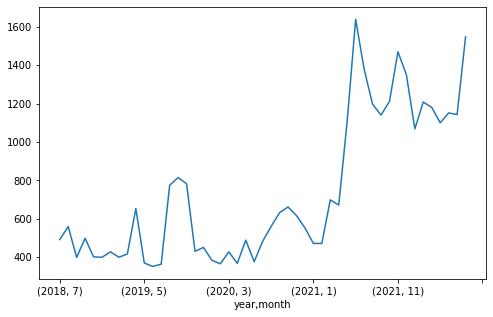

In [3]:
page_views.monthly.requests().then_plot(figsize=(8,5))

### Top 10 Most Popular Pages Last Month

Ooh, I love the traffic increase of early 2021. But now I'm wondering what pages
drew the most visitors. Let's list the top 10 most popular pages for the last
month.

Instead of picking a rate with `monthly.requests()`, we now pick a single date
range via `over.last_month()` and then select the value counts of the
`cool_path` column. That column is derived from the original `path` but maps
each value to the corresponding [cool
path](https://www.w3.org/Provider/Style/URI) by omitting the suffix if a path
ends with `/`, `/index.html`, or `/.html`.

Note that re-using the value of the `page_views` variable is just fine because
analog creates a new dataframe for each distinct clause.

In [4]:

page_views.over.last_month().value_counts("cool_path").then_print(10)

/                                        745
/blog/2019/i-feel-love                   201
/blog/2021/game-of-thrones               150
/blog                                     62
/features/ubu-trump                       44
/about/apparebit                          38
/about/robert-grimm                       30
/about/privacy                            28
/blog/2022/wrong-impression               27
/blog/2022/mapping-package-management     24
Name: cool_path, dtype: Int64


### Top 10 Most Popular Pages Last Year

Interesting. Let's do the same for the last year:

In [5]:
page_views.over.last_year().value_counts("cool_path").then_print(10)

/                              7388
/blog/2021/game-of-thrones     1765
/blog                           758
/blog/2019/i-feel-love          426
/about/robert-grimm             409
/about/apparebit                407
/blog/2022/wrong-impression     372
/about/privacy                  354
/features/ubu-trump             347
/blog/2016/hopelessness         303
Name: cool_path, dtype: Int64


### Behold, the Power of Domain Names

Interesting. It sure makes sense that my home page is #1. I similarly expect
that the blog index is popular, so #3 fits. But I didn't expect my blog posts
[Game of Thrones, US Edition](https://apparebit.com/blog/2021/game-of-thrones)
and [I Feel Love](https://apparebit.com/blog/2019/i-feel-love) to be that
popular. Mind you, they are well worth reading: The former reflects on the power
of Facebook and Twitter after Trump's attempted coup on January 6, 2021. The
latter is an open letter to Sam Smith about his risible cover of the eponymous
Donna Sumer song.

In addition to being surprisingly popular, the two blog posts share one other
trait that differentiates them from all other posts. I own two other domains,
[deface.info](http://deface.info) and [obscenely.gay](http://obscenely.gay),
that just happen to redirect to them. Since domain names are simpler and hence
easier to share than complete URLs, which surround the domain name with a
protocol and a path, them serving as popularity boosters makes sense. At the
same time, I haven't exactly advertised the two secondary domains, only
mentioning them in a couple of tweets. Still, it seems unlikely that domains
have little to no traffic-boosting effects and some other, unknown factor just
happened to boost traffic to just those two web pages.

Alas, the domain-as-content-booster hyposthesis is pretty much impossible to
prove or disprove based on the data. In theory, the `Referer` (sic) header would
provide us with just the information we need. In practice, it's mostly missing.
The reason is a bit involved: The two domain registrars for those domains offer
forwarding but do not maintain TLS certificates for the domains. Hence, the
original request an insecure HTTP request and only the redirected request is a
secure HTTPS request. According to the default referrer policy,
`strict-origin-when-cross-origin`, clients should *not* included the `Referer`
for requests with no or mixed security.

Let's check the `Referer` values on those two pages for the last year, starting
with *I Feel Love*:

In [6]:
i_feel_love = (
    page_views
    .over.last_year()
    .only.equals('cool_path', '/blog/2019/i-feel-love')
)

assert i_feel_love.requests() == 426

i_feel_love.value_counts('referrer_host').then_print()

www.google.com       149
obscenely.gay         31
apparebit.com         12
www.obscenely.gay      5
m.obscenely.gay        2
app.obscenely.gay      2
www.apparebit.com      1
www.bing.com           1
alf100.ru              1


Just as expected, 48% of last year's page views for *I Feel Love* had no
referrer. In contrast, only 31 + 5 or 8% of page views use `obscenely.gay` or
`www.obscenely.gay` as a referrer. Another 4 or 1% of page views use variations
of the name that point towards some form of security probe. Arguably, they
should count as bot traffic, too.

Oh. And: At 35% of page views, Google matters as a traffic source. A lot.

Let's check *Game of Thrones, US Edition*:

In [7]:
game_of_thrones = (
    page_views
    .over.last_year()
    .only.equals('cool_path', '/blog/2021/game-of-thrones')
)

assert game_of_thrones.requests() == 1765

game_of_thrones.value_counts('referrer_host').then_print()

deface.info          226
www.google.com       202
apparebit.com         67
info.all-url.info     18
www.deface.info       17
baidu.com              5
fbkwriter.com          2
www.bing.com           1
www.apparebit.com      1


Hmm, that's different: A whopping 69% of last year's page views for *Game of
Thrones* omit the referrer. 14% do include `deface.info` or `www.deface.info` as
a referrer. And only 11% stem from Google, which doesn't matter as much for this
page.

Overall, the lack of referrers makes it impossible to prove the
domain-as-content-booster hypothesis. At the same time, nothing in the data
contradicts it either. Hence, I'm inclined to believe that the hypothesis holds.
That has actionable consequences.

> Always make sure that `obscenely.gay` points to my gayest page and
> `deface.info` to the page most damning about Facebook!

As of this writing, the latter would be [Wrong
Impression](https://apparebit.com/blog/2022/wrong-impression), which presents
compelling evidence that Facebook is cooking the books and hence misrepresenting
its business to paying customers, investors, and regulators. I've updated
`deface.info` accordingly.

## Aside: The Benefits of Wrapping Pandas

Analog's wrapping of Pandas dataframes has three benefits:

  * A simpler and hence more usable domain-specific interface;
  * A more coherent interface that hides inconsistencies in Pandas interface;
  * A more flexible interface that enables new features.

First, Pandas exposes a powerful and flexible interface and often supports
several options for getting the same task done. That's not surprising given the
project's maturity — it started over 14 years ago — and its widespread use. But
that also gets in the way of beginning and casual users. In contrast, the very
simplicity of analog's domain-specific interface provides more guardrails for
just those users.

Second, Analog's wrappers also expose a more coherent interface where Pandas
requires distinct methods for achieving nominally similar results. Notably,
Pandas does not support `value_counts()` for grouped data and, as far as I can
tell, requires an altogether [more convoluted
calculation](https://github.com/apparebit/analog/blob/357f6d921b3eb5f37b799ccc55f9892d6077dc16/analog/analyzer.py#L143)
that first creates a multi-index over year, month, and value-counted column,
then unstacks the innermost index, and finally restores the original date range.
In contrast, analog hides those implementation differences, supporting
`monthly.value_counts("status_class")` as much as
`over.last_month().value_counts("status_class")`.

Alas, those results do differ in resulting datatype:

  * When counting requests for a time range, such as the entire log via
    `.requests()`, the result is an *integer*.
  * When calculating value counts for a time range like the above
    `.over.last_month().value_counts("status_class")`, the result is a *series*.
  * When calculating monthly request counts via `.monthly.requests()`, the result
    is a *series*.
  * When calculating monthly value counts, say,
    `monthly.value_counts("status_class")`, the result is a *dataframe*.

In the first case, analog is done wrapping and just returns the integer value.
In the other three cases, analog keeps on wrapping and subsequent display
clauses, i.e., `then_print()` and `then_plot()`, apply to series and dataframes
alike.

Finally, analog's wrappers facilitate the addition of new features. For example,
the implementation started out as eagerly applying filters and hence created a
new dataframe for every filter expression. That seems a recipe for out-of-memory
errors with large logs and hence I switched to lazily evaluating filters. That
required almost no changes in the public filter methods and instead was largely
constricted to `FluentTerm `'s `data` property and `filter()` helper method
implementations.

## Status Codes

So far, we only looked at successful GET requests for markup made by humans.
It's time to consider the full range of requests, starting with status codes.


### Four Kinds of Monthly Status Codes

Since tracking each individual status code would result in information overload,
we instead build on the derived `status_class` column. It categorizes individual
status codes into successful, redirection, client error, and server error. While
certainly coarser, this categorization seems important enough for analog to
simplify `value_counts("status_class")` to `status_classes()`.

While we are at it, we might as well produce a different graph by providing
additional keyword arguments to `then_plot()`, which just passes them on to
Pandas' `plot()` method.

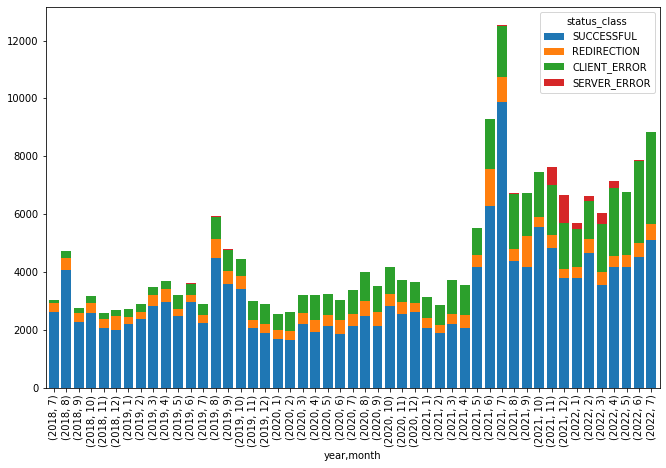

In [8]:
(
    analyze(df)
    .monthly.status_classes()
    .then_plot(kind='bar', stacked=True, width=0.8, figsize=(11,7))
)

Sweet! That's one neat looking graph. Admittedly, it took a little futzing with
plot size and column `width` because the defaults produced too small a plot with
too much space between columns.

### Top 10 Paths Resulting in Server Errors

Alas, the presence of server errors in the graph does suggest that my hosting
provider's (shared) server went through a pretty long-lasting rough patch from
November 2021 through April 2022 — with a few more server errors in June 2021,
July 2021, and June 2022. That's no good. But before calling my hosting
provider's customer service, it would be good to find out a little more about
those server errors.

/blog/2021/game-of-thrones/wp1/wp-includes/wlw...    156
/blog/2021/game-of-thrones/wp/wp-includes/wlwm...    156
/blog/2021/game-of-thrones/wordpress/wp-includ...    156
/blog/2021/game-of-thrones/web/wp-includes/wlw...    156
/blog/2021/game-of-thrones/cms/wp-includes/wlw...    156
/blog/2021/game-of-thrones/test/wp-includes/wl...    156
/blog/2021/game-of-thrones/site/wp-includes/wl...    156
/blog/2021/game-of-thrones/blog/wp-includes/wl...    151
/blog/2021/game-of-thrones/shop/wp-includes/wl...    149
/blog/2021/game-of-thrones/2019/wp-includes/wl...    149
/blog/2021/game-of-thrones/website/wp-includes...    147
/blog/2021/game-of-thrones/sito/wp-includes/wl...    147
/blog/2021/game-of-thrones/wp2/wp-includes/wlw...    147
/blog/2021/game-of-thrones/news/wp-includes/wl...    147
/blog/2021/game-of-thrones/wp-includes/wlwmani...    143
/blog/2021/game-of-thrones/2020/wp-includes/wl...     80
/blog/2021/game-of-thrones/2018/wp-includes/wl...     69
/blog/2021/game-of-thrones/medi

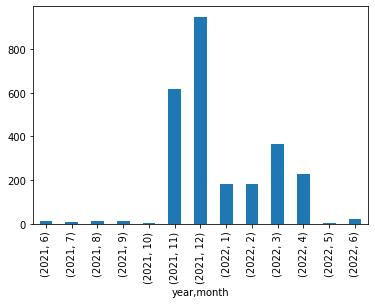

In [10]:
from analog.month_in_year import time_range

server_errors = (
    analyze(df)
    .only.server_error()
    .over.range(*time_range('2021-06', '2022-06'))
)

server_errors.monthly.requests().then_plot(kind='bar')
server_errors.value_counts('path').then_print(10)

### Top 10 Paths That Were Not Found During Last Year

As far as the far more prevalent client errors, let's find out more about them.
In particular, we are interested in 404 Not Found errors, since they may help
identify other websites using outdated links.

In [11]:
(
    analyze(df)
    .only.not_found()
    .over.last_year()
    .value_counts("path")
    .then_print(10)
)

/favicon.ico                               673
/ads.txt                                   563
/th1s_1s_a_4o4.html                        358
//cms/wp-includes/wlwmanifest.xml          306
//site/wp-includes/wlwmanifest.xml         306
//test/wp-includes/wlwmanifest.xml         306
//wp1/wp-includes/wlwmanifest.xml          306
//wordpress/wp-includes/wlwmanifest.xml    303
//wp/wp-includes/wlwmanifest.xml           302
//web/wp-includes/wlwmanifest.xml          300
Name: path, dtype: Int64


### Robot Client Errors Per Month

We would expect that robots know what they are looking for and hence have a much
smaller error rate than human traffic. Let's check that hypothesis.

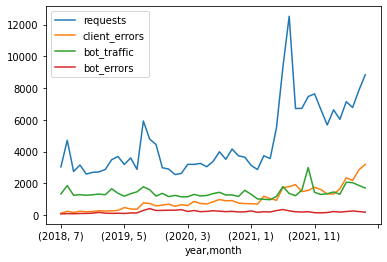

In [12]:
analog = analyze(df)

# Each phrase has its own dataframe. So we can reuse previously computed phrases.
bot_traffic = analog.only.bots()
bot_errors = bot_traffic.only.client_error()
traffic = analog
client_errors = traffic.only.client_error()

# Finish each series.
labels = ["requests", "client_errors", "bot_traffic", "bot_errors"]
series = [traffic, client_errors, bot_traffic, bot_errors]
requests = merge({n: s.monthly.requests() for n, s in zip(labels, series)})
requests.as_is.then_plot()